# Part 2

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.ar_model import ar_select_order as ARSelectOrder
from statsmodels.tsa.api import AutoReg

In [2]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Constants

FILEPATH = 'quarterly.xls'

### 1. Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes).


In [4]:
df = pd.read_excel(FILEPATH)

In [5]:
df.head(5)

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


In [6]:
df.tail(3)

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
209,2012Q2,0.15,0.09,0.19,0.79,1.82,201.80,192.83,228.84,113.60,2258.30,29611.6,9888.97,8.17,97.27,13548.5,14379.3,115.035,1104.500
210,2012Q3,0.14,0.10,0.18,0.67,1.64,202.40,195.20,230.03,113.91,2326.47,30251.4,10029.87,8.03,97.39,13652.5,14441.9,115.810,1119.187
211,2012Q4,0.16,0.09,0.17,0.69,1.71,202.27,196.20,231.28,114.18,2436.73,30938.8,10319.60,7.83,98.01,13665.4,14505.4,116.089,1147.623


In [7]:
df.shape

(212, 19)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      212 non-null    object 
 1   FFR       212 non-null    float64
 2   Tbill     212 non-null    float64
 3   Tb1yr     212 non-null    float64
 4   r5        212 non-null    float64
 5   r10       212 non-null    float64
 6   PPINSA    212 non-null    float64
 7   Finished  212 non-null    float64
 8   CPI       212 non-null    float64
 9   CPICORE   212 non-null    float64
 10  M1NSA     212 non-null    float64
 11  M2SA      212 non-null    float64
 12  M2NSA     212 non-null    float64
 13  Unemp     212 non-null    float64
 14  IndProd   212 non-null    float64
 15  RGDP      212 non-null    float64
 16  Potent    212 non-null    float64
 17  Deflator  212 non-null    float64
 18  Curr      212 non-null    float64
dtypes: float64(18), object(1)
memory usage: 31.6+ KB


We can see that there are no missing values in this dataset. However, as asked, we make sure of dropping them using `df.dropna()`

In [9]:
df = df.dropna()

We parse the datetimes to a more convenient format using `pd.to_datetime()`

In [10]:
df["DATE"] = pd.to_datetime(df.DATE)

In [11]:
df.head(1)

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.2,29.4,18.92,140.53,896.1,299.4,5.13,23.93,2845.3,2824.2,18.521,31.83


We will make sure that the dataset is not missing information from any quarter:

In [12]:
first_date = df.DATE[0]
last_date = df.DATE[df.shape[0] - 1]
qs = pd.date_range(start=first_date, end=last_date, freq='QS')
len(qs.difference(df.DATE))

0

With this result we have shown that there is no value missing for any quarter.

### 2. Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez.

The formula for computing inflation given the CPI can be written as:

$$inf = 100 * \frac{CPI_{final} - CPI_{initial}}{CPI_{initial}}$$

In [13]:
# Create a new column to get the CPI from the previous quarter
df["prev_CPI"] = df.CPI.shift(1)

In [14]:
df.head(3)

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr,prev_CPI
0,1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830,NaN
1,1960-04-01,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862,29.40
2,1960-07-01,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217,29.57


In [15]:
df["inf"] = 100 * ((df.CPI - df.prev_CPI) / df.prev_CPI)

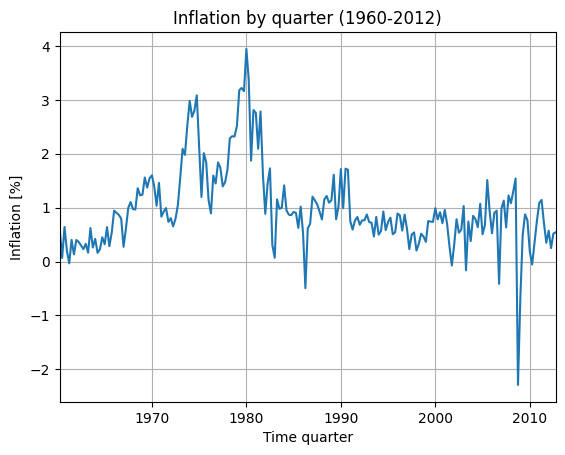

In [16]:
inf = df.inf.to_numpy()[1:]

plt.plot(df.DATE[1:], inf)
plt.title('Inflation by quarter (1960-2012)', fontsize=12)
plt.xlabel('Time quarter')
plt.ylabel('Inflation [%]')
plt.xlim(df.DATE[1], last_date)
plt.grid()
plt.show()

In [17]:
df.inf.min()

-2.2891346065978335

In [18]:
df.inf.describe()

count    211.000000
mean       0.985290
std        0.774504
min       -2.289135
25%        0.541995
50%        0.857677
75%        1.221306
max        3.945811
Name: inf, dtype: float64

In [19]:
min_inf_date = pd.Timestamp(df[df.inf == df.inf.min()].DATE.values[0]).date()
max_inf_date = pd.Timestamp(df[df.inf == df.inf.max()].DATE.values[0]).date()
print(f"Minimum inflation date: {min_inf_date}")
print(f"Maximum inflation date: {max_inf_date}")

Minimum inflation date: 2008-10-01
Maximum inflation date: 1980-01-01



We can observe a general tendency where the inflation is always around 1% by quarter. However, between 1970 and 1980 we find some **peaks of growth**, reaching a **maximum value of almost 4%** by quarter in **1980**. After some research, we may conclude that this was mainly due to oil crisis. Then, we find the **minimum peak in 2008**, probably due to the [collapse of Lehman Brothers](https://www.investopedia.com/articles/economics/09/lehman-brothers-collapse.asp#:~:text=Lehman%20Brothers%20filed%20for%20bankruptcy,the%20financial%20and%20investment%20world.).

### 3. Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de inf. Quelle est la différence entre ces deux graphiques ?

The autocorrelogram for `inf` by definition is, given a `lag k`, the autocorrelation between the values of the series that are `k` intervals away.

*Observation: value for lag `k = 0` will always be `1`!*

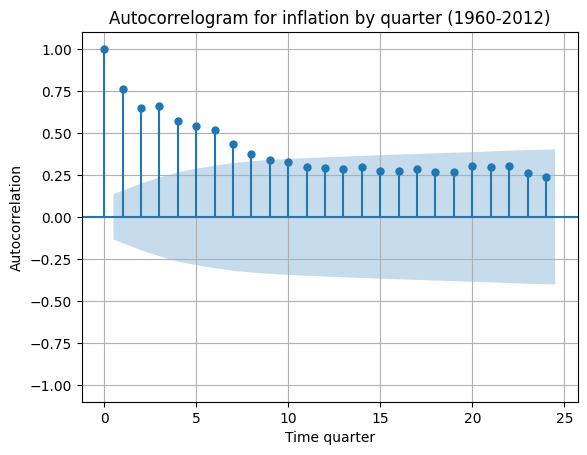

In [20]:
plot_acf(inf)
plt.title('Autocorrelogram for inflation by quarter (1960-2012)', fontsize=12)
plt.xlabel('Time quarter')
plt.ylabel('Autocorrelation')
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()

The values outside the blue region have a high statistical confidence (above 95%). We see that there is a high correlation for every value outside this region, in particular, for lag until `k=6` we find that the correlation is higher that 0.5.

Now we are interested in the partial autocorrelagram, that is the same as the autocorrelagram, but taking into account the values for intermediate intervals. This method allows us to mitigate the effects of the observations between `t` and `t - k` (`lag k`), removing indirect correlations included in the autocorrelogram.

*Observation: we can expect, by definition, that for lag `k = 0` and `k = 1`, values will be the same that the ones seen in the previous graphic.*

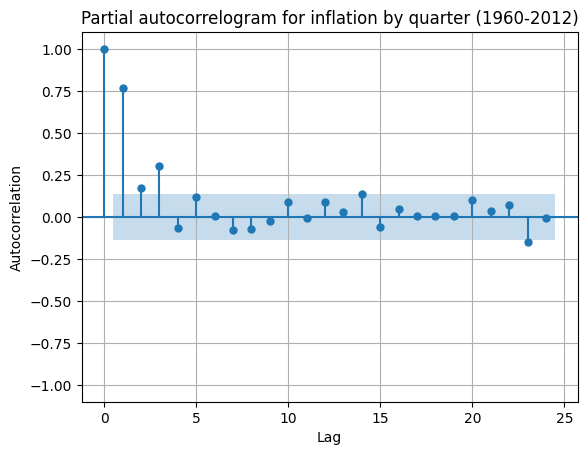

In [22]:
plot_pacf(inf)
plt.title('Partial autocorrelogram for inflation by quarter (1960-2012)', fontsize=12)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()

By definition, for any Autoregressive model of order `k`, the partial autocorrelations are 0 for every lag beyond `k`. Given that, in our case, we have values until `k = 3` that are non-zero and outside the blue region (confidence over 95%), we can estimate that inflation can be predicted with a model of order `k = 3`.

### 4. Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions. 

In the context of stationary series, we have:

* A **stationary time series** if its properties do not depend on the time at which the series is observed. Future and past are similar.
* A **ergodicity time series** if its statistics can be deduced from any (large enough) random sample given from the process, meaning that they do not depend on the initial conditions.

We need these conditions to be true, since they are the **basic assumptions needed** to perform time series analysis. They are also needed to apply the *ergodic theorem*, which allows us to estimate the expectation of the process given the average of a sufficiently large sample.

### 5. Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.

We are building an Auto Regression model for inf, and we want to discover which is the order that maximizes likelihood. From question 3, we are expecting a value of 3 to be the optimal order. However, we are using [`ar_select_order`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.ar_select_order.html) from `statsmodel` API for Time Series to check the optimal lag value:

In [23]:
model = ARSelectOrder(inf, maxlag=10, glob=True)
model.ar_lags

[1, 3]

In [24]:
print(model.model.fit().summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  211
Model:              Restr. AutoReg(3)   Log Likelihood                -138.549
Method:               Conditional MLE   S.D. of innovations              0.471
Date:                Sun, 27 Nov 2022   AIC                            285.099
Time:                        19:28:15   BIC                            298.449
Sample:                             3   HQIC                           290.497
                                  211                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1352      0.056      2.394      0.017       0.025       0.246
y.L1           0.5742      0.056     10.321      0.000       0.465       0.683
y.L3           0.2894      0.056      5.207      0.0

### 6. Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante.

In [25]:
df.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,...,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr,prev_CPI,inf
0,1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,...,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830,NaN,NaN
1,1960-04-01,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,...,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862,29.40,0.578231
2,1960-07-01,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,...,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217,29.57,0.067636
3,1960-10-01,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,...,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624,29.59,0.642109
4,1961-01-01,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,...,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073,29.78,0.201478


We build a model as learned in the course:

In [32]:
sm.OLS

statsmodels.regression.linear_model.OLS

In [26]:
unemp = df.Unemp[1:]
y = unemp
const = np.ones(y.shape)
X = np.column_stack((const, inf))

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01214
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.912
Time:                        19:28:22   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0708      0.181     33.576      0.0

The estimated model would be:
$$Unemp = 6.0708 + 0.0159 Inf$$

### 7. Tester l’autocorrélation des erreurs.

We will first plot the residuals:

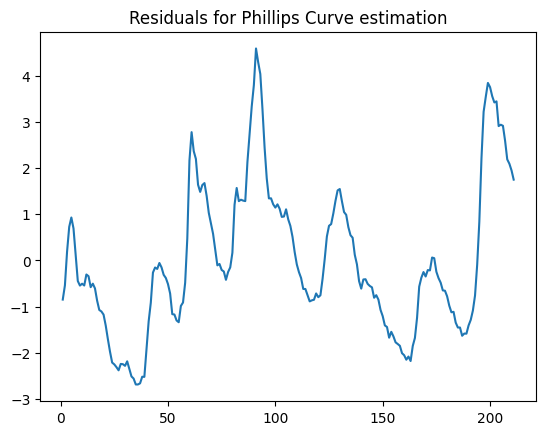

In [27]:
res = results.resid
plt.plot(res)
plt.title('Residuals for Phillips Curve estimation')
plt.show()

From the course results, we know that for a model `AR(1)`, residuals can be written as:
$$u_t = \rho u_{t - 1} + e_t $$

Then, we can set our hypothesis:
$$H_0 : { \rho = 0 };\quad H_1 : { \rho \neq 0 }$$

We build then our model `AR(1)` for the residuals of the Phillips Curve estimation from previous question:

In [46]:
res_model = AutoReg(res, lags=1)
res_results = res_model.fit()
res_results.pvalues

const    0.600587
y.L1     0.000000
dtype: float64


We observe that the p-value for $\rho$ is approximately 0, so we reject the null hypothesis that errors are serially uncorrelated at 5%, to conclude that **they are autocorrelated**.